In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")
df_test = pd.read_excel("C:\\Users\\2K\\Desktop\\test.xlsx")

df_train 


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [13]:
df_train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


Исходный график

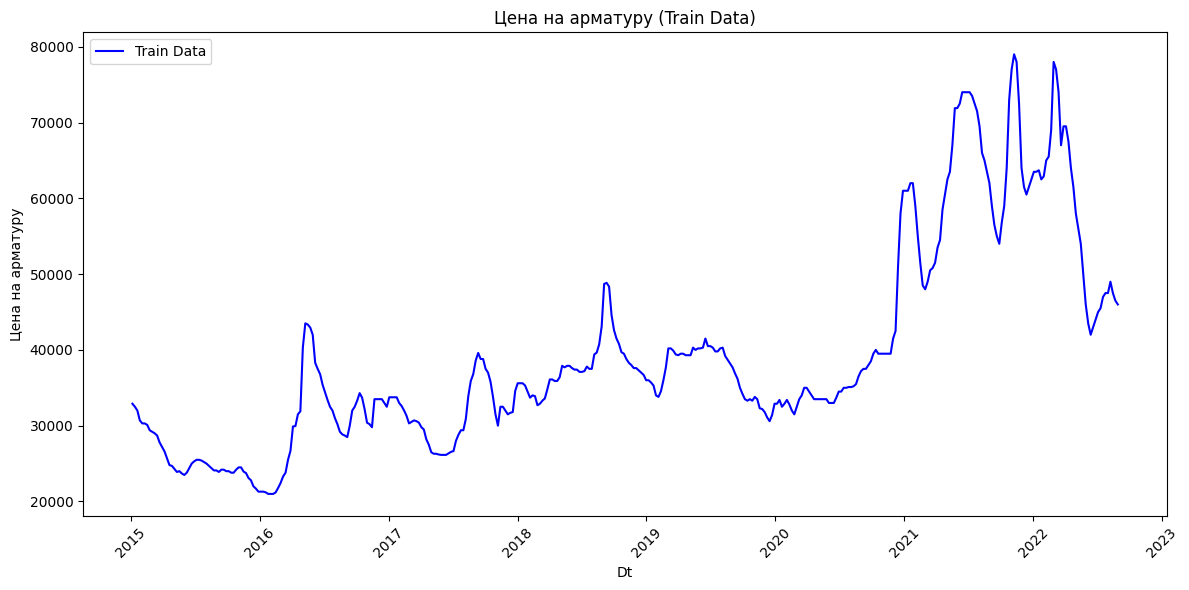

In [3]:
# Загрузка данных

df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")


# Преобразование столбца 'dt' в datetime
df_train['dt'] = pd.to_datetime(df_train['dt'])

# Визуализация цен
plt.figure(figsize=(12, 6))
plt.plot(df_train['dt'], df_train['Цена на арматуру'], label='Train Data', color='blue')
plt.xlabel('Dt')
plt.ylabel('Цена на арматуру')
plt.title('Цена на арматуру (Train Data)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Очистка данных

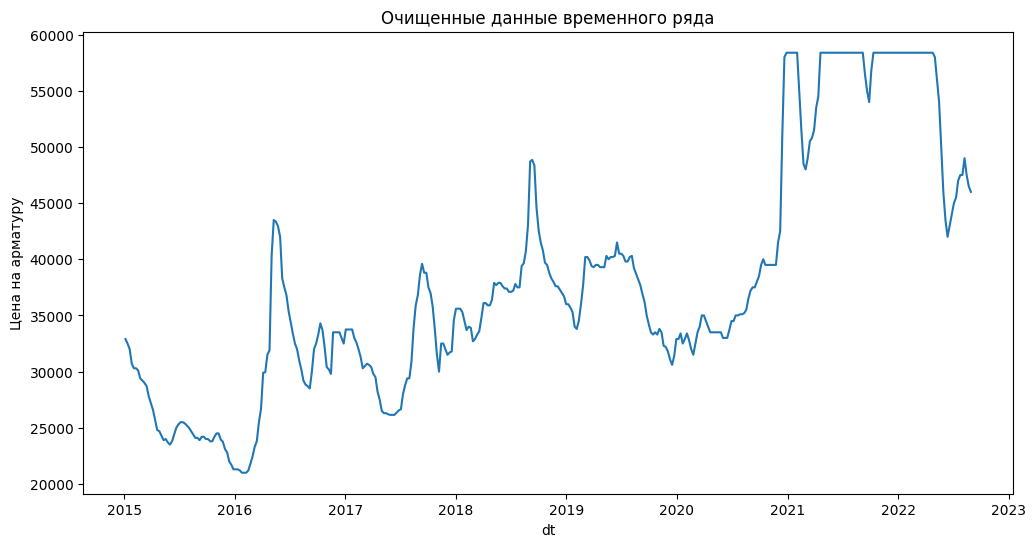

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def clean_data(df, date_col, value_col):
    # Заполнение пропусков линейной интерполяцией
    df[value_col] = df[value_col].interpolate(method='linear')
    
    # Удаление выбросов с помощью IQR
    Q1, Q3 = df[value_col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[value_col] = df[value_col].clip(lower, upper)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_col], df[value_col])
    plt.title("Очищенные данные временного ряда")
    plt.xlabel(date_col)
    plt.ylabel(value_col)
    plt.show()
    
    return df

# --- Пример использования ---

df = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])
df_cleaned = clean_data(df.copy(), 'dt', 'Цена на арматуру')
      

Разложение времянного ряда

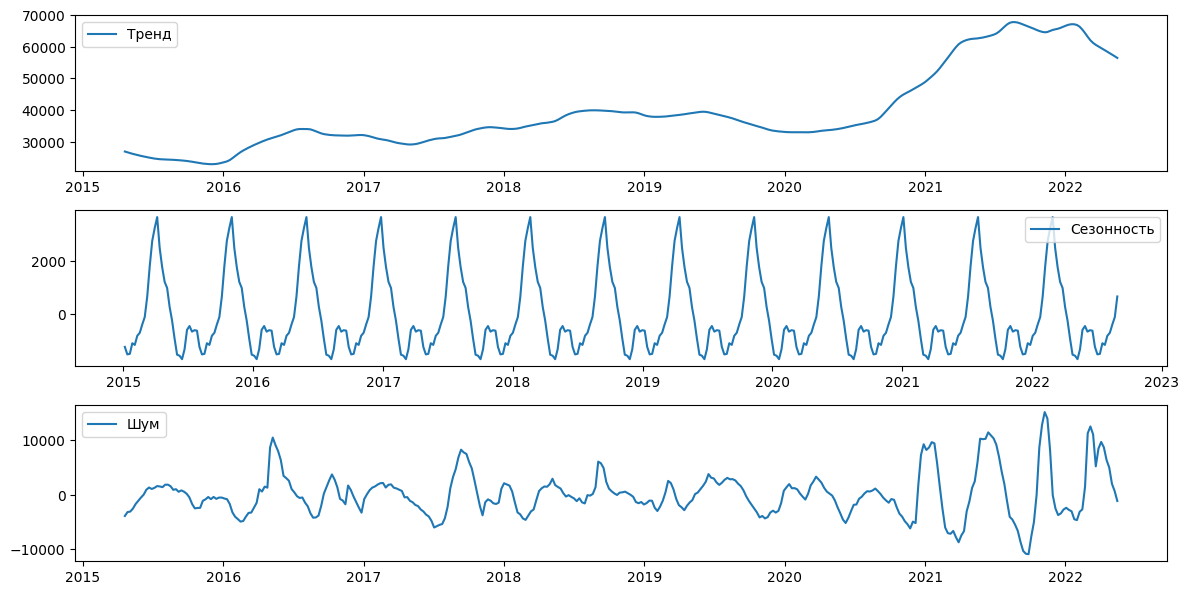

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных
df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'], index_col='dt')


# Разложение временного ряда
decomposition = seasonal_decompose(df_train['Цена на арматуру'], model='additive', period=30)


# Визуализация компонентов
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(decomposition.trend, label='Тренд')
plt.legend()

plt.subplot(312)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()

plt.subplot(313)
plt.plot(decomposition.resid, label='Шум')
plt.legend()

plt.tight_layout()
plt.show()

Графики ACF и PACF

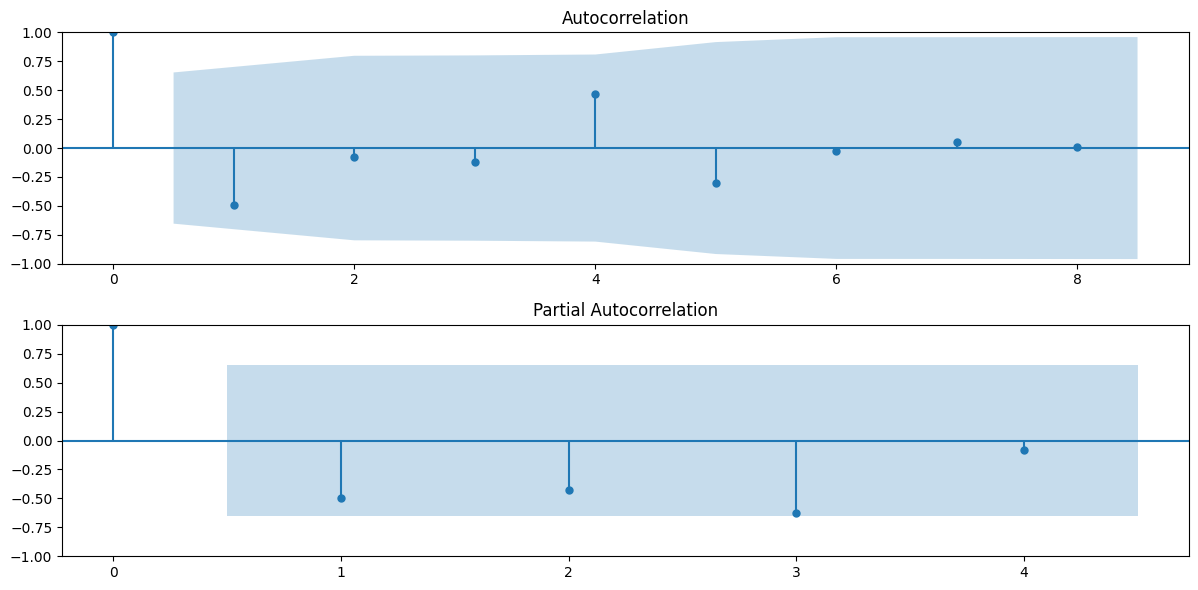

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = [10, 12, 15, 13, 16, 18, 20, 19, 22, 24] 
series = pd.Series(data)
series_diff = series.diff().dropna()

# 2. Построение графиков ACF и PACF ДЛЯ ДИФФЕРЕНЦИРОВАННОГО РЯДА
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(series_diff, ax=ax1, lags=len(series_diff) - 1)
plot_pacf(series_diff, ax=ax2, lags=min(len(series_diff) // 2, len(series_diff) - 1), method='ywm')
plt.tight_layout()
plt.show()

Обучение модели Prophet

12:41:58 - cmdstanpy - INFO - Chain [1] start processing


Установлен cap: 64226.25


12:41:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


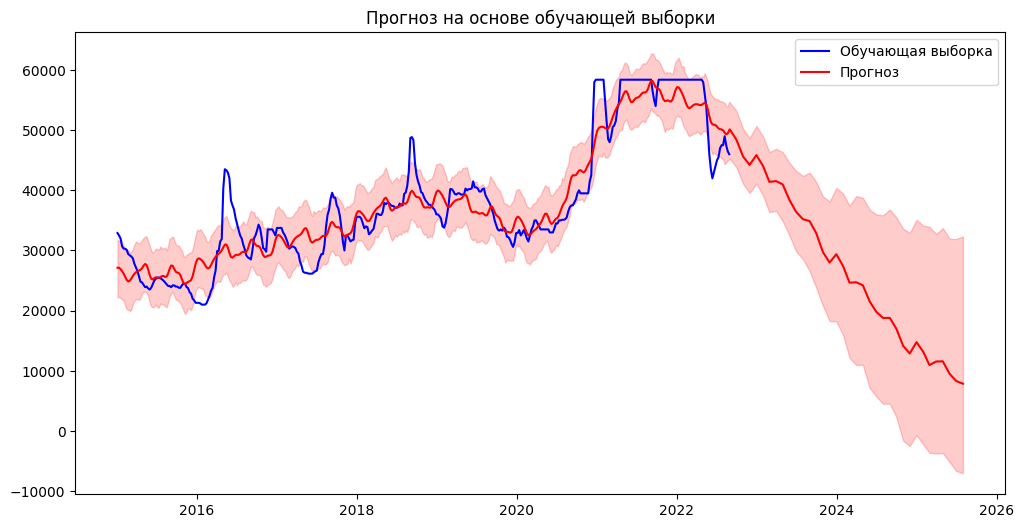

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# --- 1. Загрузка данных ---    
data = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])
data = data.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})


# --- 2. Обработка пропущенных значений и выбросов ---
def clean_data(df, value_column):
    # Пропущенные значения
    if df[value_column].isnull().any():
        df[value_column] = df[value_column].interpolate(method='linear')
    
    # Выбросы (IQR)
    Q1, Q3 = df[value_column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[value_column] = df[value_column].clip(lower, upper)
    return df

data = clean_data(data, 'y')


train = data 

# --- 4. Настройка параметра cap ---
cap = train['y'].max() * 1.1  # Максимальное значение + 10% буфера
print(f"Установлен cap: {cap:.2f}")

# Добавляем cap ко всем данным
train['cap'] = cap

# --- 5. Обучение модели Prophet ---
model = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    seasonality_prior_scale=20,  
    changepoint_prior_scale=0.5,  
    changepoint_range=0.9  
)

model.fit(train)

# --- 6. Прогнозирование ---
future = model.make_future_dataframe(periods=36, freq='M')  # Прогноз на 3 года вперед
future['cap'] = cap
forecast = model.predict(future)

# --- 7. Визуализация результатов ---
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label='Обучающая выборка', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Прогноз на основе обучающей выборки")
plt.show()

12:45:41 - cmdstanpy - INFO - Chain [1] start processing


Установлен cap: 53735.00


12:45:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Mean Squared Error на тестовой выборке: 1271842597.07


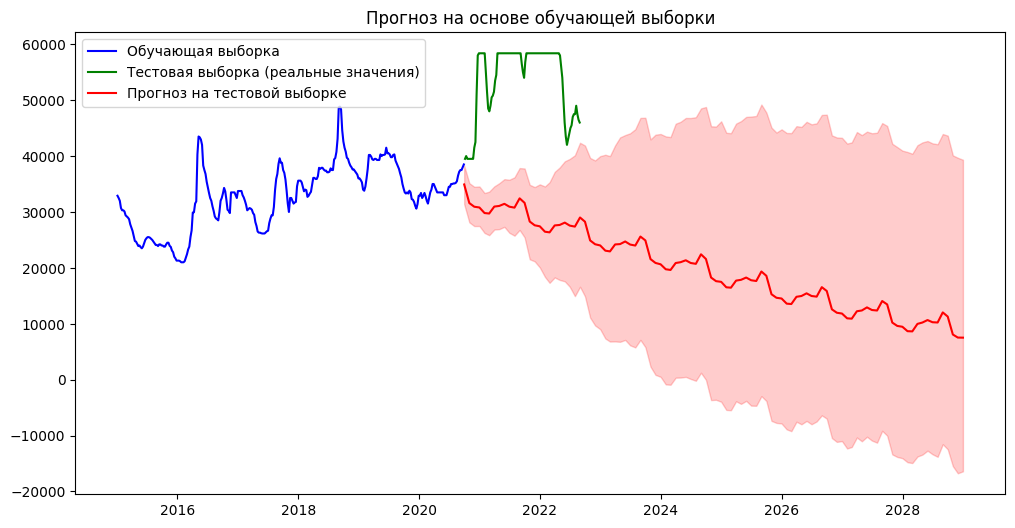

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# --- 1. Загрузка данных ---

    # Загружаем данные из файла
data = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'])
data = data.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})


# --- 2. Обработка пропущенных значений и выбросов ---
def clean_data(df, value_column):
    # Пропущенные значения
    if df[value_column].isnull().any():
        df[value_column] = df[value_column].interpolate(method='linear')
    
    # Выбросы (IQR)
    Q1, Q3 = df[value_column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[value_column] = df[value_column].clip(lower, upper)
    return df

data = clean_data(data, 'y')

# --- 3. Разделение данных на обучающую (75%) и тестовую (25%) выборки ---
train_data, test_data = train_test_split(data, test_size=0.25, shuffle=False)

# --- 4. Настройка параметра cap ---
cap = train_data['y'].max() * 1.1 # Максимальное значение + 10% буфера
print(f"Установлен cap: {cap:.2f}")

# Добавляем cap к обучающим данным
train_data['cap'] = cap

# --- 5. Обучение модели Prophet ---
model = Prophet(
growth='logistic',
yearly_seasonality=True,
seasonality_prior_scale=20,
changepoint_prior_scale=0.5,
changepoint_range=0.9
)
model.fit(train_data)

# --- 6. Прогнозирование на тестовой выборке ---
# Создаем датасет для прогноза на период тестовой выборки
test_data['cap'] = cap
future = model.make_future_dataframe(periods=len(test_data), freq='M') # Прогноз на длину тестовой выборки
future['cap'] = cap

forecast = model.predict(future)

# Извлекаем прогнозы только для тестовой выборки
test_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test_data))
test_forecast = test_forecast.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# --- 7. Оценка качества модели ---
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
print(f"Mean Squared Error на тестовой выборке: {mse:.2f}")

# --- 8. Визуализация результатов ---
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Обучающая выборка', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Тестовая выборка (реальные значения)', color='green')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Прогноз на тестовой выборке', color='red')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Прогноз на основе обучающей выборки")
plt.show()